In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Activation,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline
scaler = MinMaxScaler()

In [3]:
df = pd.read_csv('owid-covid-data.csv') # data from Our World In Data until 13 Jan 2022
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
df_sg = df[df['location'] == 'Singapore']
df_sg.tail()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
125202,SGP,Asia,Singapore,2022-01-09,285647.0,845.0,765.286,838.0,1.0,1.286,...,5.2,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN
125203,SGP,Asia,Singapore,2022-01-10,286397.0,750.0,806.143,838.0,0.0,1.286,...,5.2,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN
125204,SGP,Asia,Singapore,2022-01-11,287243.0,846.0,806.714,838.0,0.0,0.857,...,5.2,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN
125205,SGP,Asia,Singapore,2022-01-12,288125.0,882.0,817.714,839.0,1.0,0.714,...,5.2,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN
125206,SGP,Asia,Singapore,2022-01-13,289085.0,960.0,838.714,839.0,0.0,0.571,...,5.2,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN


In [5]:
df_sg_new = df_sg[['date', 'new_cases']]
df_sg_new.tail()

,date,new_cases
125202,2022-01-09,845.0
125203,2022-01-10,750.0
125204,2022-01-11,846.0
125205,2022-01-12,882.0
125206,2022-01-13,960.0


In [7]:
df_sg_new = df_sg_new.set_index('date')
df_sg_new

,new_cases
date,
2020-01-23,1.0
2020-01-24,2.0
2020-01-25,0.0
2020-01-26,1.0
2020-01-27,1.0
...,...
2022-01-09,845.0
2022-01-10,750.0
2022-01-11,846.0


<AxesSubplot:xlabel='date'>

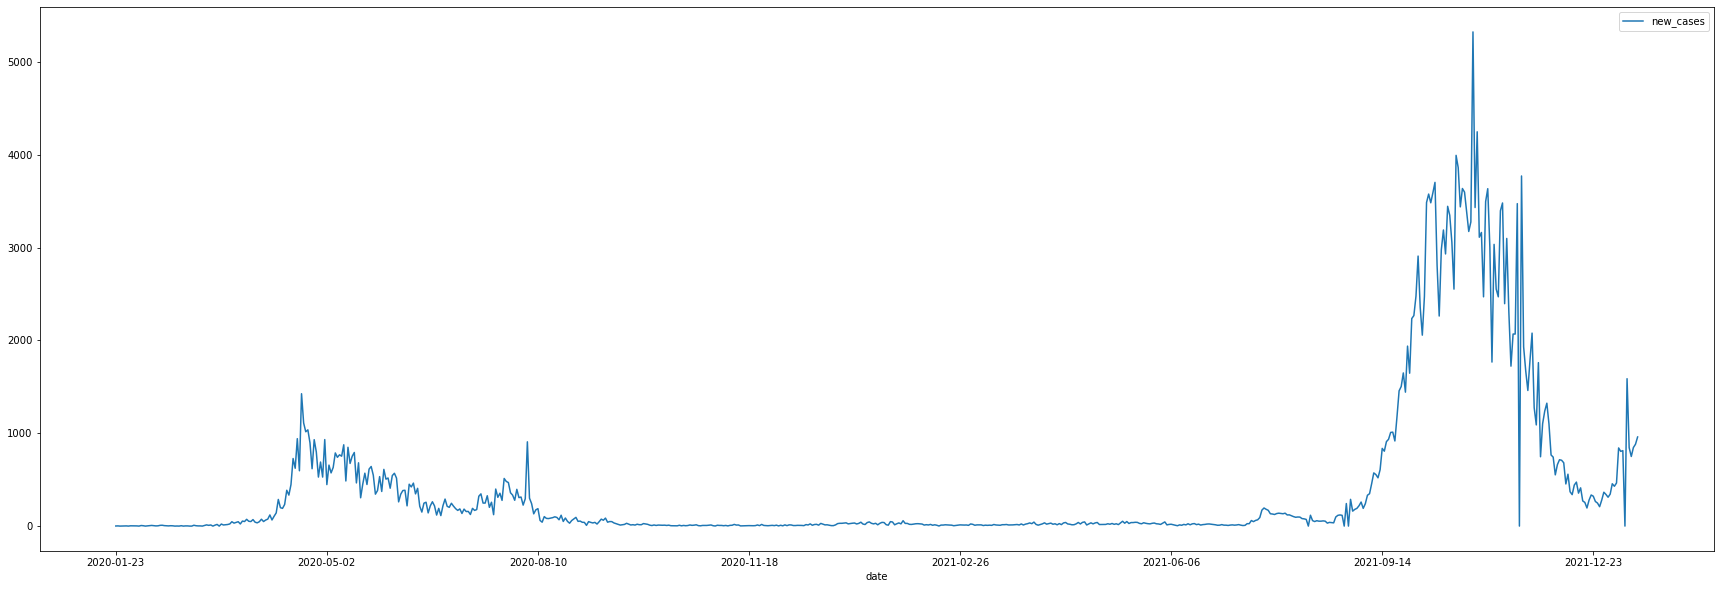

In [9]:
df_sg_new.plot(figsize=(30, 10))

Machine Learning processes start here:

In [10]:
day = 90 # Number of days for the window size of time-series data

In [11]:
k = 0

array = []
array_temp = []
train_data = []
train_labels = []

for i in range(len(df_sg_new)):
    array_temp.append(df_sg_new.iloc[i]['new_cases'])

array_temp = np.array(array_temp).reshape(-1,1)
array_temp = scaler.fit_transform(array_temp)
array_temp = array_temp.tolist()

for i in array_temp:
    array.append(i[0])

for i in range(len(array)):
    try:
        train_data.append(array[k:day+k]) # Creating inner lists with 'day' days of data
        train_labels.append([array[day+k]])
        k+=1
    except:
        break

# Last rows contain None as the total size of array is not divisible by 'day'
length = max(map(len, train_data))
train_data=np.array([xi+[None]*(length-len(xi)) for xi in train_data]).astype('float32')

length = max(map(len, train_labels))
train_labels = np.array([xi+[None]*(length-len(xi)) for xi in train_labels]).astype('float32')

In [12]:
# Shape of the training and the label dataset:
print(train_data.shape)
print(train_labels.shape)

(633, 90)
(632, 1)


In [13]:
# Expand the dimensions of the training dataset for the LSTM architecture
train_data = train_data[:len(train_labels)]
train_data = np.expand_dims(train_data,1)
train_data.shape

(632, 1, 90)

In [14]:
train_data[1]

array([[3.75657401e-04, 0.00000000e+00, 1.87828700e-04, 1.87828700e-04,
        3.75657401e-04, 0.00000000e+00, 5.63486072e-04, 5.63486072e-04,
        5.63486072e-04, 3.75657401e-04, 0.00000000e+00, 1.12697214e-03,
        7.51314801e-04, 0.00000000e+00, 3.75657401e-04, 5.63486072e-04,
        1.31480093e-03, 9.39143472e-04, 3.75657401e-04, 5.63486072e-04,
        1.50262960e-03, 1.69045827e-03, 9.39143472e-04, 5.63486072e-04,
        3.75657401e-04, 7.51314801e-04, 5.63486072e-04, 0.00000000e+00,
        1.87828700e-04, 0.00000000e+00, 7.51314801e-04, 0.00000000e+00,
        3.75657401e-04, 3.75657401e-04, 0.00000000e+00, 0.00000000e+00,
        1.69045827e-03, 7.51314801e-04, 3.75657401e-04, 3.75657401e-04,
        0.00000000e+00, 1.31480093e-03, 2.44177319e-03, 1.50262960e-03,
        2.25394429e-03, 0.00000000e+00, 1.87828694e-03, 3.38091655e-03,
        0.00000000e+00, 4.13223123e-03, 2.25394429e-03, 2.62960186e-03,
        3.19308788e-03, 4.32005990e-03, 8.82794894e-03, 6.010518

In [15]:
train_labels[1]

array([0.19477837], dtype=float32)

In [16]:
# Build LSTM architecture
model = Sequential()

model.add(LSTM(250,input_shape=(1,day)))
model.add(Dropout(0.5))


model.add(Dense(250,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(day,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='relu'))

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 250)               341000    
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               62750     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                22590     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9

In [17]:
# Training: Fit data to the model
E = 1000
callback = EarlyStopping(monitor='loss', mode='min', patience=20)
H = model.fit(train_data,train_labels,epochs=E, verbose=0, callbacks=[callback])

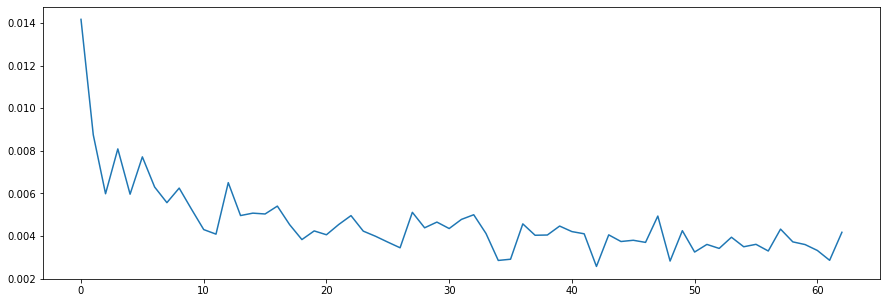

In [18]:
# After training is done, plot of loss value for each epoch
loss = H.history['loss']
epochs = range(0,len(loss))
plt.figure(figsize=(15,5))
plt.plot(epochs,loss)

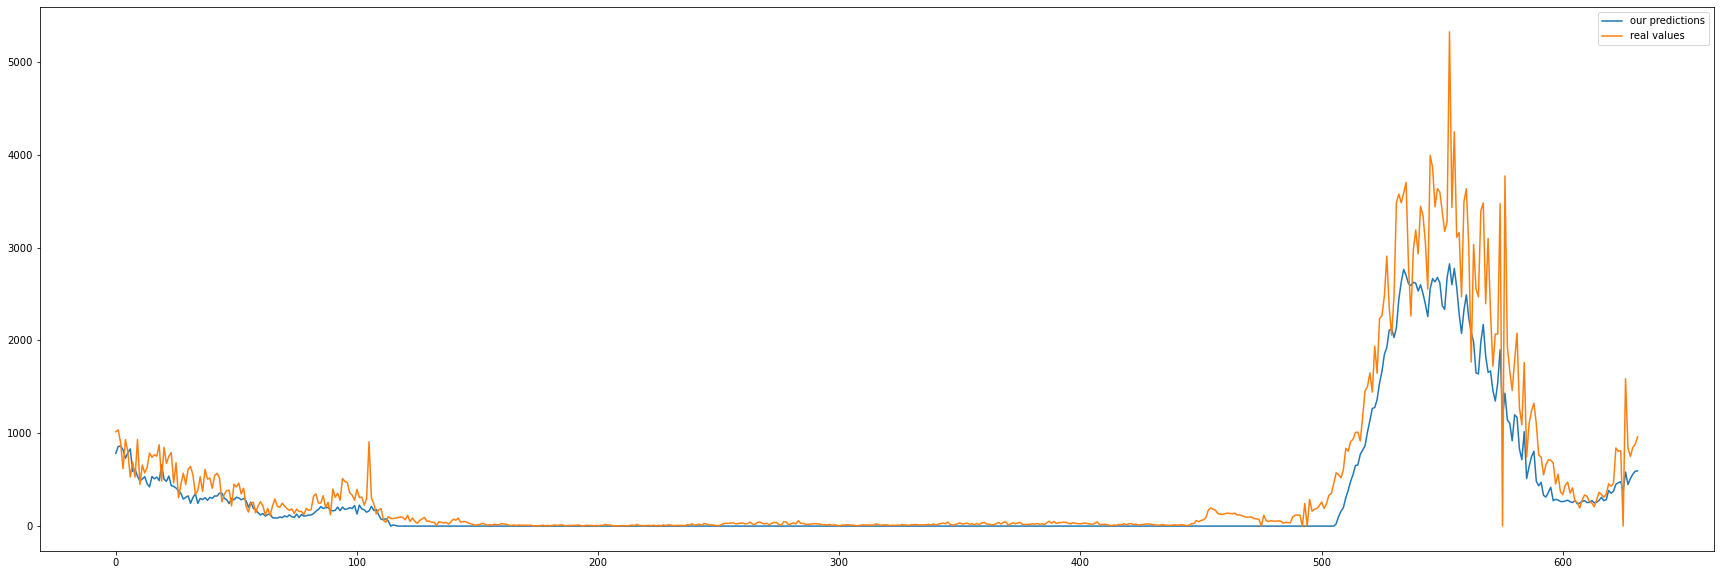

In [19]:
preds = scaler.inverse_transform(model.predict(train_data))
plt.figure(figsize=(30,10))
plt.plot(preds,label='our predictions')
plt.plot(scaler.inverse_transform(train_labels),label='real values')
plt.legend()

In [20]:
# Future predictions for 90 days since 13 Jan 2022
days_to_predict = 90
seed = array[-day:]

In [21]:
for _ in range(days_to_predict):
    current_days = seed[-day:]
    current_days = np.squeeze(current_days)
    current_days = np.expand_dims(current_days,0)
    current_days = np.expand_dims(current_days,0)
    pred = model.predict(current_days)
    seed = np.append(seed,pred)

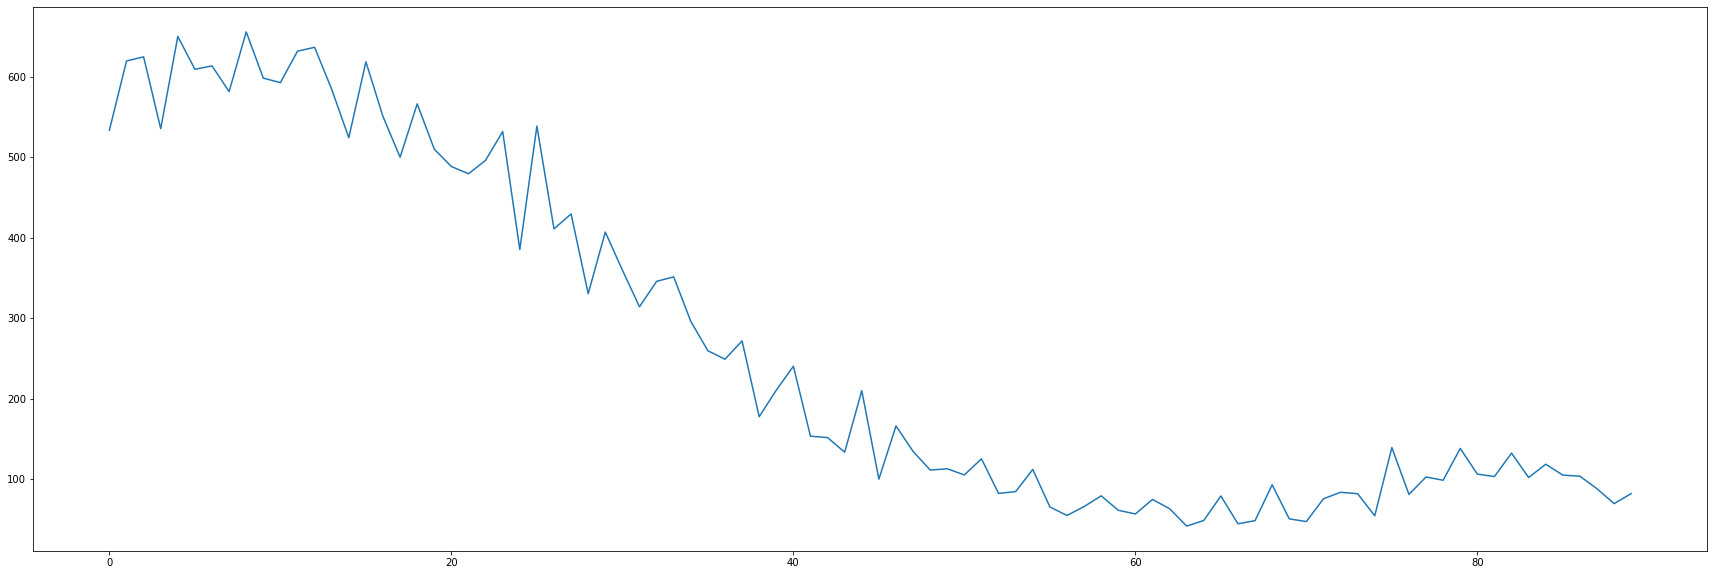

In [22]:
upcoming_days_prediction = scaler.inverse_transform(seed[-days_to_predict:].reshape(-1,1))
plt.figure(figsize=(30,10))
plt.plot(range(0,days_to_predict),upcoming_days_prediction)

In [23]:
# Adding real values and predicted values together
arr_without_pred = scaler.inverse_transform(train_labels)
arr_pred = scaler.inverse_transform(seed[-days_to_predict:].reshape(-1,1))
arr_with_pred = np.concatenate((arr_without_pred, arr_pred))

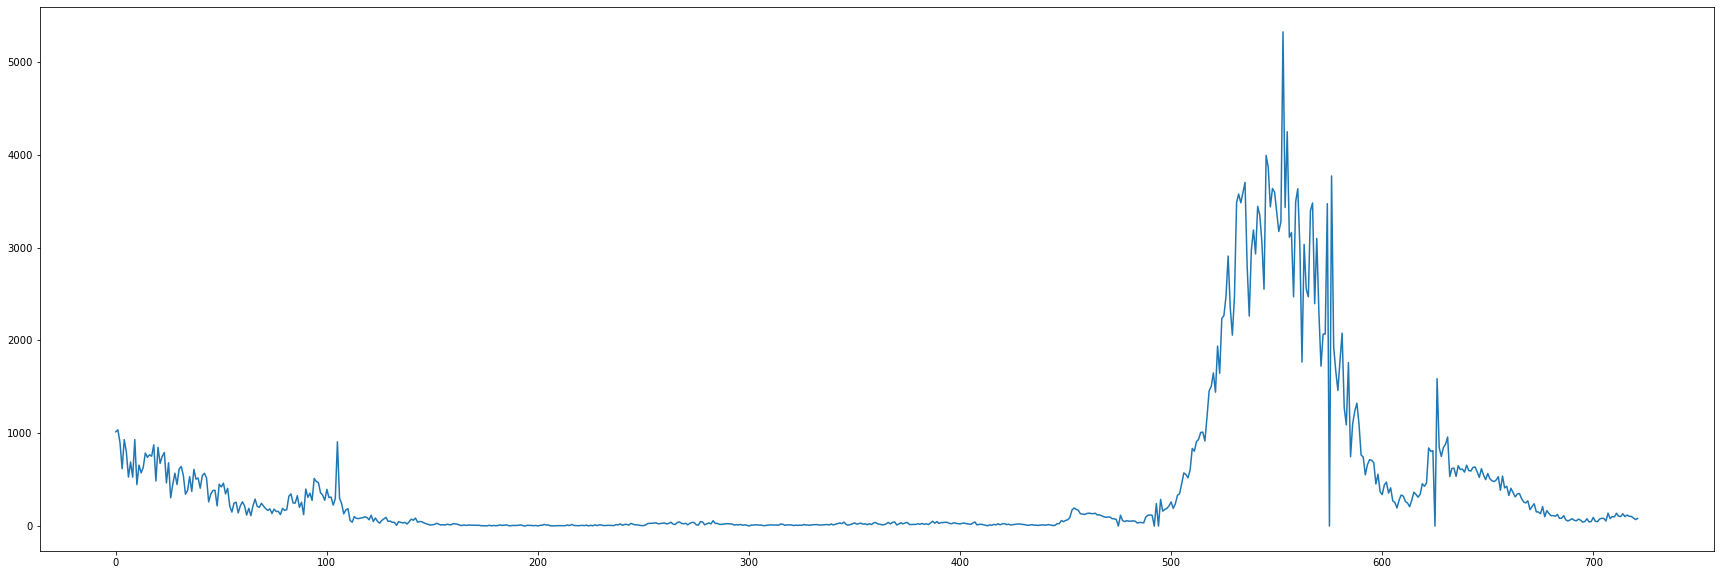

In [24]:
plt.figure(figsize=(30,10))
plt.plot(arr_with_pred)

In [25]:
total_new_cases = 0
for i in upcoming_days_prediction:
    total_new_cases += i[0]
print(total_new_cases)

23964.85158276558
